In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib as mpl
import cartopy.crs as ccrs
import cartopy

import geopandas
import cartopy.io.shapereader as shpreader
import shapely

In [2]:
degrees = 2.5
tdf = pd.read_csv(f'../data/study_da_6 - Temperature - upper_pred_{degrees}.csv')
tdf["da_var"] = "Temperature"
pdf = pd.read_csv(f'../data/study_da_6 - Precipitation - upper_pred_{degrees}.csv')
pdf["da_var"] = "Precipitation"

df = pd.concat([tdf,pdf])

df = df[pd.notna(df["gridcells"]) & df["gridcells"]>0]

df["da_trend_p"] = df["da_trend_cells"] / df["gridcells"]

places =  pd.read_csv('../data/place_df.csv')

In [3]:
df = pd.read_csv('../data/1_predicted_category_documents.csv')


In [4]:
pred_cats = [c for c  in df.columns if "12 - " in c and " - mean_prediction" in c]
for c in pred_cats:
    print(df[c].sum())
    label = c.replace(" - mean_prediction",'')
    df.loc[df[label]==1,c] = 1
    print(df[c].sum())
print(pred_cats)

pred_cats = [
    "12 - Terrestrial ES - mean_prediction",
    "12 - Coastal and marine Ecosystems - mean_prediction",
    "12 - Mountains, snow and ice - mean_prediction",
    "12 - Rivers, lakes, and soil moisture - mean_prediction",
    "12 - Human and managed - mean_prediction"
]



12442.299999999997
12615.299999999997
9111.599999999999
9360.599999999999
4556.7
4715.700000000001
11711.900000000001
12003.900000000003
29771.3
30213.3
['12 - Coastal and marine Ecosystems - mean_prediction', '12 - Human and managed - mean_prediction', '12 - Mountains, snow and ice - mean_prediction', '12 - Rivers, lakes, and soil moisture - mean_prediction', '12 - Terrestrial ES - mean_prediction']


In [5]:
df_places = df.merge(places, left_on="id", right_on="doc_id")
df_places = df_places[pd.notna(df_places['lat'])]
df_places.head()

,Unnamed: 0,id,content,title,wosarticle__de,wosarticle__wc,ar5,seen,relevant,random_sample,...,country_conf,doc_id,admin1,lat,lon,country_code3,geonameid,place_name,feature_class,feature_code
0,0,13201,It is still difficult to confirm from availabl...,An Overview of Extreme Hot Weather Incidents a...,heatwave; extreme hot weather; natural ventila...,['Construction & Building Technology; Energy &...,NaN,0.0,0.0,0,...,0.905268,13201,NaN,39.00000,141.00000,JPN,2110769.0,Tōhoku Chihō,L,RGN
1,0,13201,It is still difficult to confirm from availabl...,An Overview of Extreme Hot Weather Incidents a...,heatwave; extreme hot weather; natural ventila...,['Construction & Building Technology; Energy &...,NaN,0.0,0.0,0,...,0.946458,13201,NaN,35.68536,139.75309,JPN,1861060.0,Japan,A,PCLI
2,0,13201,It is still difficult to confirm from availabl...,An Overview of Extreme Hot Weather Incidents a...,heatwave; extreme hot weather; natural ventila...,['Construction & Building Technology; Energy &...,NaN,0.0,0.0,0,...,0.939398,13201,NaN,15.50000,101.00000,THA,1605651.0,Kingdom of Thailand,A,PCLI
3,0,13201,It is still difficult to confirm from availabl...,An Overview of Extreme Hot Weather Incidents a...,heatwave; extreme hot weather; natural ventila...,['Construction & Building Technology; Energy &...,NaN,0.0,0.0,0,...,0.534384,13201,NaN,30.00000,70.00000,NaN,1168579.0,Islamic Republic of Pakistan,A,PCLI
4,0,13201,It is still difficult to confirm from availabl...,An Overview of Extreme Hot Weather Incidents a...,heatwave; extreme hot weather; natural ventila...,['Construction & Building Technology; Energy &...,NaN,0.0,0.0,0,...,0.946458,13201,Fukushima,37.38158,140.22199,JPN,2112922.0,Fukushima-ken,A,ADM1


In [6]:
from scipy.interpolate import interp1d
def extend_points(p1,p2,length=0.8):
    p3 = [None,None]
    lenAB = np.sqrt((p1[0]-p2[0])**2 + (p1[1]-p2[1])**2)
    p3[0] = p2[0] + (p2[0] - p1[0]) / lenAB*length
    p3[1] = p2[1] + (p2[1] - p1[1]) / lenAB*length
    return p3

def chaikins_corner_cutting(coords, refinements=5):

    for _ in range(refinements):
        L = coords.repeat(2, axis=0)
        R = np.empty_like(L)
        R[0] = L[0]
        R[2::2] = L[1:-1:2]
        R[1:-1:2] = L[2::2]
        R[-1] = L[-1]
        coords = L * 0.75 + R * 0.25

    return coords

def flatten(container):
    for i in container:
        if isinstance(i, (list,tuple)):
            for j in flatten(i):
                yield j
        else:
            yield i


110


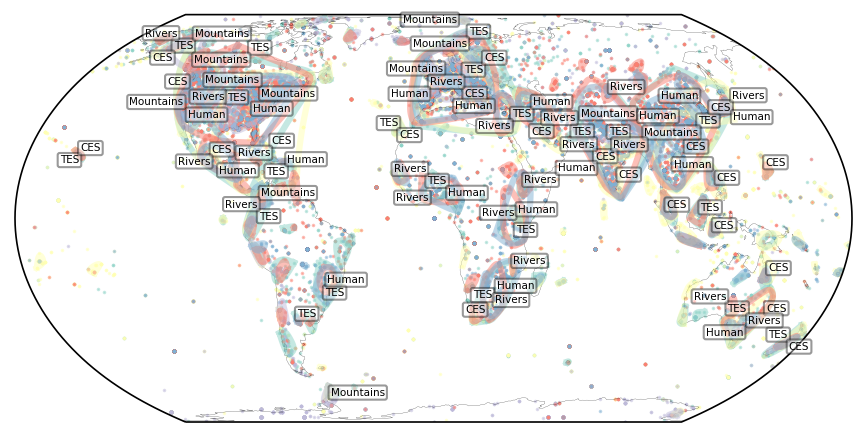

In [7]:
from sklearn.cluster import DBSCAN
from scipy.spatial import ConvexHull
from adjustText import adjust_text, get_renderer, get_bboxes

plt.figure(dpi=150, figsize=(7.2,3.6))


ax = plt.axes(projection=ccrs.EqualEarth())

ax.coastlines(lw=0.1)

transform = ccrs.PlateCarree()._as_mpl_transform(ax)

words_only=False
min_cluster = 20
min_title_cluster = 100
clabel_size=5

xticks = [
    "TES",
    "CES",
    "Mountains, snow and ice",
    "Rivers, lakes\n and soil moisture",
    "Human",    
]

colors = ['#8dd3c7','#ffffb3','#bebada','#fb8072','#80b1d3']

texts = []

for i, c in enumerate(pred_cats):
    title = xticks[i]
    cdf = df_places[df_places[c]>0.5]
    ax.scatter(cdf['lon'],cdf['lat'],s=0.5, alpha=0.5, transform=ccrs.PlateCarree(), color=colors[i])
    points = np.array(list(zip(cdf['lon'],cdf['lat'])))
    
    
    db = DBSCAN(eps=3, min_samples=20).fit(points)
    labels = db.labels_
    
    bboxes = []
    r = get_renderer(ax.get_figure())
    for l in set(labels):
        text_set = False
        if l==-1:
            continue
        ind = np.argwhere(labels==l)[:,0]
        #print("\n##\nlabel: {}, {} documents".format(l,len(ind)))
        lpoints = points[ind]
        if len(ind) > min_cluster:
            try:
                hull = ConvexHull(lpoints)
            except:
                continue
            cx = np.mean(hull.points[hull.vertices,0])
            cy = np.mean(hull.points[hull.vertices,1])
            c = [cx,cy]


            if words_only:
                title = title.split(",")[0].replace("{","")

                text = ax.annotate(
                    title, c, fontsize=clabel_size,
                    ha="center",va="center",
                    bbox={'facecolor':"white", 'alpha':0.4, 'pad':0.2, 'boxstyle': 'round'},
                    xycoords=transform,
                )
                texts.append(text)
                print(c)
                #return text
                #break

            else:
                title = title.split(",")[0].replace("{","")
                x = []
                y = []
                for j, v in enumerate(lpoints[hull.vertices,:]):
                    p1 = extend_points(c,v)
                    #p2 = extend_points(c,v])
                    x.append(p1[0])
                    y.append(p1[1])
                    if len(ind) >= min_title_cluster:
                        if not text_set:
                            if p1[0] > cx:
                                ha = "left"
                            else:
                                ha = "right"
                            pl = extend_points(c,p1)
                            texts.append(ax.text(
                                c[0],
                                c[1],
                                title,
                                #c,
                                #p1,
                                #xytext=pl,
                                va="center",
                                #ha=ha,
                                ha="center",
                                fontsize=clabel_size,
                                #arrowprops=dict(width=0.2,headwidth=0.1),
                                bbox={'facecolor':"white", 'alpha':0.4, 'pad':0.2, 'boxstyle': 'round'},
                                transform=ccrs.PlateCarree()
                            ))
                            text_set = True
                orig_len = len(x)
                x = x[-3:-1] + x + x[1:3]
                y = y[-3:-1] + y + y[1:3]

                t = np.arange(len(x))
                ti = np.linspace(2, orig_len + 1, 10 * orig_len)

                x2 = interp1d(t, x, kind='cubic')(ti)
                y2 = interp1d(t, y, kind='cubic')(ti)


                x = lpoints[hull.vertices,0]
                x = np.append(x,[x[:1]])
                y = lpoints[hull.vertices,1]
                y = np.append(y,[y[:1]])
                coords = np.array(list(zip(x,y)))
                coords = chaikins_corner_cutting(coords)


                x2 = coords[:,0]
                y2 = coords[:,1]

                #x2 = interpolate.BSpline(t, x, nt)
                #y2 = interpolate.BSpline(t, y, nt)
                plt.plot(x2, y2,'-',linewidth=3, alpha=0.5, transform=ccrs.PlateCarree(), color=colors[i])
                
    texts = list(flatten(texts))
    
texts = list(flatten(texts))
x = adjust_text(
    texts,ax=ax, 
    arrowprops=dict(arrowstyle="->", color='None', lw=0.5), 
    #expand_text=(2.5,2.5), 
    avoid_points=False,
    #precision=0.005
)
    
print(x)
plt.show()

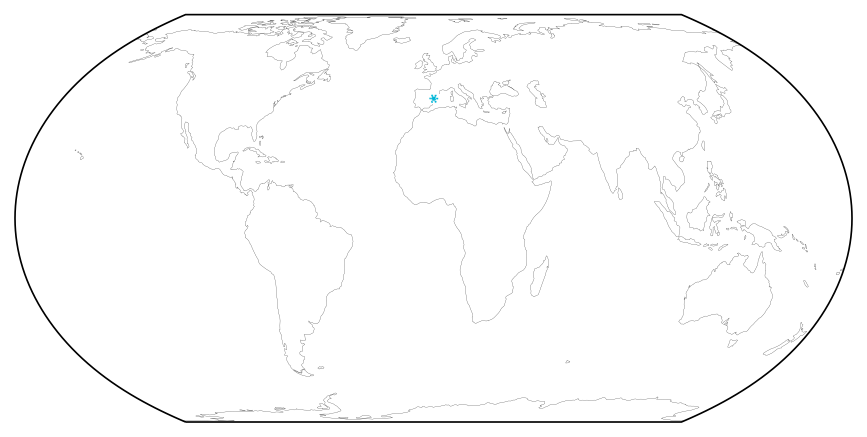

In [9]:
from matplotlib.offsetbox import (TextArea, DrawingArea, OffsetImage,
                                  AnnotationBbox)

plt.figure(dpi=150, figsize=(7.2,3.6))


ax = plt.axes(projection=ccrs.EqualEarth())

ax.coastlines(lw=0.1)

transform = ccrs.PlateCarree()._as_mpl_transform(ax)

fn="icons/ice.png"

arr_img = plt.imread(fn, format='png')

imagebox = OffsetImage(arr_img, zoom=0.3)
imagebox.image.axes = ax

ab = AnnotationBbox(imagebox, (0,40),            
                    xycoords=transform,
                    pad=-0.1
                    )

ax.add_artist(ab)

[134.      138.51562 136.9     134.     ]


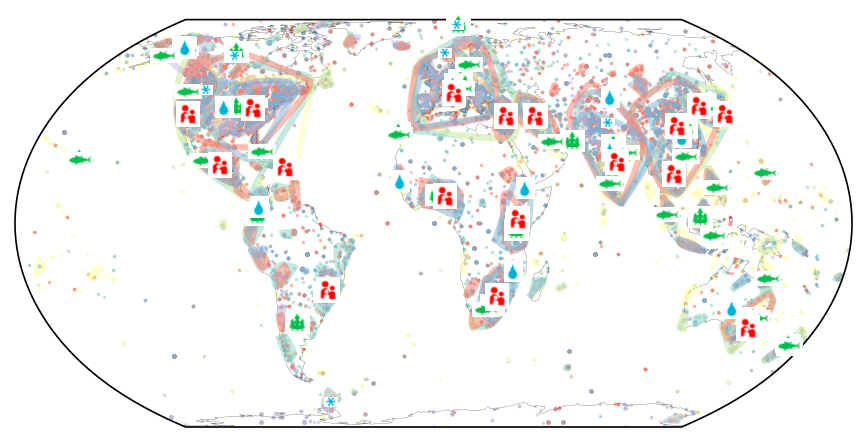

In [13]:
from sklearn.cluster import DBSCAN
from scipy.spatial import ConvexHull
from adjustText import adjust_text, get_renderer, get_bboxes

plt.figure(dpi=150, figsize=(7.2,3.6))


ax = plt.axes(projection=ccrs.EqualEarth())

ax.coastlines(lw=0.1)

transform = ccrs.PlateCarree()._as_mpl_transform(ax)

words_only=False
min_cluster = 20
min_title_cluster = 100
clabel_size=5

xticks = [
    "TES",
    "CES",
    "Mountains, snow and ice",
    "Rivers, lakes\n and soil moisture",
    "Human",    
]

colors = ['#8dd3c7','#ffffb3','#bebada','#fb8072','#80b1d3']

texts = []

fns = [
    "icons/tes.png",
    "icons/mes.png",
    "icons/ice.png",
    "icons/rivs.png",
    "icons/hum.png"
]





for i, c in enumerate(pred_cats):
    title = xticks[i]
    cdf = df_places[df_places[c]>0.5]
    ax.scatter(cdf['lon'],cdf['lat'],s=0.5, alpha=0.5, transform=ccrs.PlateCarree(), color=colors[i])
    points = np.array(list(zip(cdf['lon'],cdf['lat'])))
    
    arr_img = plt.imread(fns[i], format='png')
    
    
    db = DBSCAN(eps=3, min_samples=20).fit(points)
    labels = db.labels_
    
    bboxes = []
    r = get_renderer(ax.get_figure())
    for l in set(labels):
        text_set = False
        if l==-1:
            continue
        ind = np.argwhere(labels==l)[:,0]
        #print("\n##\nlabel: {}, {} documents".format(l,len(ind)))
        lpoints = points[ind]
        if len(ind) > min_cluster:
            try:
                hull = ConvexHull(lpoints)
            except:
                continue
            cx = np.mean(hull.points[hull.vertices,0])
            cy = np.mean(hull.points[hull.vertices,1])
            c = [cx,cy]


            if words_only:
                title = title.split(",")[0].replace("{","")
                


#                 text = ax.annotate(
#                     title, c, fontsize=clabel_size,
#                     ha="center",va="center",
#                     bbox={'facecolor':"white", 'alpha':0.4, 'pad':0.2, 'boxstyle': 'round'},
#                     xycoords=transform,
#                 )
                texts.append(text)
                print(c)
                #return text
                #break

            else:
                title = title.split(",")[0].replace("{","")
                x = []
                y = []
                for j, v in enumerate(lpoints[hull.vertices,:]):
                    p1 = extend_points(c,v)
                    #p2 = extend_points(c,v])
                    x.append(p1[0])
                    y.append(p1[1])
                    if len(ind) >= min_title_cluster:
                        if not text_set:
                            if p1[0] > cx:
                                ha = "left"
                            else:
                                ha = "right"
                            pl = extend_points(c,p1)
                            
                            imagebox = OffsetImage(arr_img, zoom=0.3)
                            imagebox.image.axes = ax

                            ab = AnnotationBbox(imagebox, c,            
                                                xycoords=transform,
                                                pad=-0.1
                                                )

                            text = ax.add_artist(ab)
                            texts.append(text)
                            
#                             texts.append(ax.text(
#                                 c[0],
#                                 c[1],
#                                 title,
#                                 #c,
#                                 #p1,
#                                 #xytext=pl,
#                                 va="center",
#                                 #ha=ha,
#                                 ha="center",
#                                 fontsize=clabel_size,
#                                 #arrowprops=dict(width=0.2,headwidth=0.1),
#                                 bbox={'facecolor':"white", 'alpha':0.4, 'pad':0.2, 'boxstyle': 'round'},
#                                 transform=ccrs.PlateCarree()
#                             ))
                            text_set = True
                orig_len = len(x)
                x = x[-3:-1] + x + x[1:3]
                y = y[-3:-1] + y + y[1:3]

                t = np.arange(len(x))
                ti = np.linspace(2, orig_len + 1, 10 * orig_len)

                x2 = interp1d(t, x, kind='cubic')(ti)
                y2 = interp1d(t, y, kind='cubic')(ti)


                x = lpoints[hull.vertices,0]
                x = np.append(x,[x[:1]])
                y = lpoints[hull.vertices,1]
                y = np.append(y,[y[:1]])
                coords = np.array(list(zip(x,y)))
                coords = chaikins_corner_cutting(coords)


                x2 = coords[:,0]
                y2 = coords[:,1]

                #x2 = interpolate.BSpline(t, x, nt)
                #y2 = interpolate.BSpline(t, y, nt)
                plt.plot(x2, y2,'-',linewidth=3, alpha=0.5, transform=ccrs.PlateCarree(), color=colors[i])
                
    texts = list(flatten(texts))
    
texts = list(flatten(texts))
# x = adjust_text(
#     texts,ax=ax, 
#     arrowprops=dict(arrowstyle="->", color='None', lw=0.5), 
#     #expand_text=(2.5,2.5), 
#     avoid_points=False,
#     #precision=0.005
# )
    
print(x)
plt.show()